In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.compose import TransformedTargetRegressor
import xgboost as xgb
import joblib
import seaborn as sns

In [2]:
# 1. Load Data
# ================================
df = pd.read_excel(r'E:\khaled\Machine learning\Models\Gas\Model TMU & Tracer.xlsx')

In [47]:
# 2. Feature Engineering
# ================================
df['flow_energy'] = df['THP (bar)'] * df['Venturi ΔP1 (mbar)']
df['temp_pressure'] = df['FLT ©'] * df['THP (bar)']
df['log_THP']       = np.log1p(df['THP (bar)'])
df['Pressure_ratio'] = df['FLP (bar)'] / df['THP (bar)']
df['dp1_dp2'] = df['Venturi ΔP1 (mbar)'] * df['Venturi ΔP2 (mbar)']         # 	Liquid-rich interaction
df['condensate_correction'] = df['temp_pressure'] / df['FLP (bar)'].clip(lower=1e-3) 
df['dP_ratio'] = np.where(
    df['Venturi ΔP1 (mbar)'] != 0,
    df['Venturi ΔP2 (mbar)'] / df['Venturi ΔP1 (mbar)'],
    0.0
)

In [49]:
skew_values = df.skew()
print("Skewness of each numerical column:")
print(skew_values)

Skewness of each numerical column:
THP (bar)                1.849659
FLP (bar)                0.365391
Choke (%)               -2.951812
FLT ©                   -0.583600
Gas Specific Gravity    -0.930946
Oil Gravity (API)        3.975035
Venturi ΔP1 (mbar)       3.643074
Venturi ΔP2 (mbar)       1.841971
Gas Rate (MMSCF/D)       2.157593
Condensate Rate (BPD)    3.168843
Water Rate (BPD)         0.772112
flow_energy              5.475804
temp_pressure            1.232467
log_THP                 -0.969732
Pressure_ratio          -2.537631
dp1_dp2                  6.091436
condensate_correction    2.958603
dP_ratio                 6.888921
dtype: float64


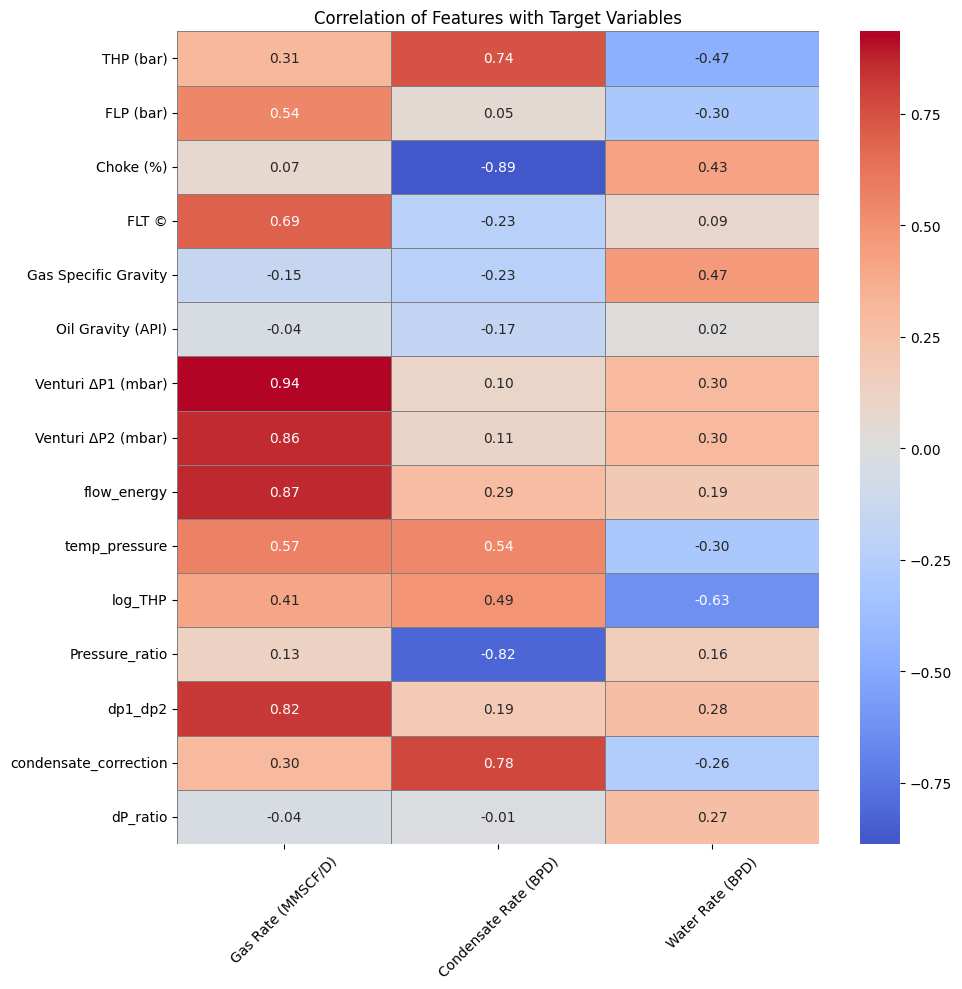

In [50]:
# --- Correlation Matrix and Heatmap ---
# Compute the correlation matrix
targets = ['Gas Rate (MMSCF/D)', 'Condensate Rate (BPD)', 'Water Rate (BPD)']
corr_matrix = df.corr()
focused_corr = corr_matrix[targets].drop(targets, errors='ignore')
# Plot heatmap with numbers
plt.figure(figsize=(10, 10))
sns.heatmap(focused_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            cbar=True, linewidths=0.5, linecolor='gray')

plt.title("Correlation of Features with Target Variables")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [51]:
# 3. Features and Target
# ================================
FEATURES = [
    'THP (bar)', 'FLP (bar)', 'FLT ©', 'Choke (%)',
    'Gas Specific Gravity', 'Oil Gravity (API)',
    'Venturi ΔP1 (mbar)', 'Venturi ΔP2 (mbar)', 'Pressure_ratio', 'dp1_dp2',
    'dP_ratio', 'flow_energy', 'temp_pressure', 'condensate_correction'
]

X = df[FEATURES]
y_g = df['Gas Rate (MMSCF/D)']
y_c  = df['Condensate Rate (BPD)']
y_w  = df['Water Rate (BPD)']

# 4. Train/test split
X_train, X_test, y_g_train, y_g_test, y_c_train, y_c_test, y_w_train, y_w_test = train_test_split(
    X, y_g, y_c, y_w, test_size=0.2, random_state=42
)

In [52]:
# 5. Build pipelines

## 5a. Gas & water multioutput with XGBoost
pipe_g = Pipeline([
    ('scaler', RobustScaler()),
    ('model', TransformedTargetRegressor(
        regressor=xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        func=np.log1p,          # Apply log1p to TARGET before training
        inverse_func=np.expm1   # Apply expm1 to predictions
    ))
])


## 5b. Condensate with log-transform
pipe_c = Pipeline([
    ('scaler', RobustScaler()),
    ('model', TransformedTargetRegressor(
        regressor=xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        func=np.log1p,          # Apply log1p to TARGET before training
        inverse_func=np.expm1   # Apply expm1 to predictions
    ))
])

## 5b. water
pipe_w = Pipeline([
    ('scaler', RobustScaler()),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

In [53]:
# 6. Hyperparameter spaces
param_g = {
    'model__regressor__n_estimators': [100, 200, 300,350,400,450],
    'model__regressor__max_depth': [3, 6, 8,10,12,14],
    'model__regressor__learning_rate': [0.005,0.01, 0.05, 0.1,0.15],
    'model__regressor__subsample': [0.6, 0.8, 1.0],
    'model__regressor__colsample_bytree': [0.6, 0.8, 1.0],
}

param_c = {
    'model__regressor__n_estimators': [100, 200, 300,350,400,450],
    'model__regressor__max_depth': [3, 6, 8,10,12,14],
    'model__regressor__learning_rate': [0.005,0.01, 0.05, 0.1,0.15],
    'model__regressor__subsample': [0.6, 0.8, 1.0],
    'model__regressor__colsample_bytree': [0.6, 0.8, 1.0],
}

param_w = {
    'model__regressor__n_estimators': [100, 200, 300,350,400,450],
    'model__regressor__max_depth': [3, 6, 8,10,12,14],
    'model__regressor__learning_rate': [0.005,0.01, 0.05, 0.1,0.15],
    'model__regressor__subsample': [0.6, 0.8, 1.0],
    'model__regressor__colsample_bytree': [0.6, 0.8, 1.0],
}

In [54]:
# 5) Multi‐metric scoring: R2 (higher better), MAE & RMSE (lower better)
scoring = {
    'R2': make_scorer(r2_score),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
                        greater_is_better=False)
}

# 6) Set up RandomizedSearchCV for each
search_g = RandomizedSearchCV(
    pipe_g, param_distributions=param_g, n_iter=50, cv=10,
    scoring=scoring, refit='RMSE',  # refit on lowest RMSE
    n_jobs=-1, random_state=42, verbose=1
)

search_c = RandomizedSearchCV(
    pipe_c, param_distributions=param_c, n_iter=50, cv=10,
    scoring=scoring, refit='RMSE',
    n_jobs=-1, random_state=42, verbose=1
)

search_w = RandomizedSearchCV(
    pipe_w, param_distributions=param_w, n_iter=50, cv=10,
    scoring=scoring, refit='RMSE',
    n_jobs=-1, random_state=42, verbose=1
)

search_g.fit(X_train, y_g_train)
search_c.fit(X_train, y_c_train)
search_w.fit(X_train, y_w_train)

best_g = search_g.best_estimator_
best_c  = search_c.best_estimator_
best_w  = search_w.best_estimator_

print("G best params:", search_g.best_params_)
print("C  best params:", search_c.best_params_)
print("w  best params:", search_w.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Fitting 10 folds for each of 50 candidates, totalling 500 fits


c:\Users\ebkas11\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [11:40:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "regressor__colsample_bytree", "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators", "regressor__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


G best params: {'model__regressor__subsample': 0.6, 'model__regressor__n_estimators': 400, 'model__regressor__max_depth': 12, 'model__regressor__learning_rate': 0.05, 'model__regressor__colsample_bytree': 1.0}
C  best params: {'model__regressor__subsample': 0.8, 'model__regressor__n_estimators': 450, 'model__regressor__max_depth': 12, 'model__regressor__learning_rate': 0.05, 'model__regressor__colsample_bytree': 0.8}
w  best params: {'model__regressor__subsample': 0.6, 'model__regressor__n_estimators': 350, 'model__regressor__max_depth': 6, 'model__regressor__learning_rate': 0.01, 'model__regressor__colsample_bytree': 0.6}


In [55]:
# 8. Evaluate on test set
y_g_pred = best_g.predict(X_test)
y_c_pred  = best_c.predict(X_test)
y_w_pred  = best_w.predict(X_test)


# Gas metrics
r2_g  = r2_score(y_g_test, y_g_pred)
mae_g = mean_absolute_error(y_g_test, y_g_pred)
rmse_g= np.sqrt(mean_squared_error(y_g_test, y_g_pred))
print(f"{'Gas rate':12s} → R²: {r2_g:.3f}, MAE: {mae_g:.2f}, RMSE: {rmse_g:.2f}")

# Condensate metrics
r2_c  = r2_score(y_c_test, y_c_pred)
mae_c = mean_absolute_error(y_c_test, y_c_pred)
rmse_c= np.sqrt(mean_squared_error(y_c_test, y_c_pred))
print(f"{'Condensate rate':12s} → R²: {r2_c:.3f}, MAE: {mae_c:.2f}, RMSE: {rmse_c:.2f}")

# Water metrics
r2_w  = r2_score(y_w_test, y_w_pred)
mae_w = mean_absolute_error(y_w_test, y_w_pred)
rmse_w= np.sqrt(mean_squared_error(y_w_test, y_w_pred))
print(f"{'Water rate':12s} → R²: {r2_w:.3f}, MAE: {mae_w:.2f}, RMSE: {rmse_w:.2f}")

# 9. Save models
joblib.dump(best_g, 'model_g_xgb.pkl')
joblib.dump(best_c, 'model_c_xgb.pkl')
joblib.dump(best_w, 'model_w_xgb.pkl')


Gas rate     → R²: 0.996, MAE: 0.18, RMSE: 0.49
Condensate rate → R²: 0.996, MAE: 6.18, RMSE: 27.37
Water rate   → R²: 0.982, MAE: 2.40, RMSE: 5.46


['model_w_xgb.pkl']

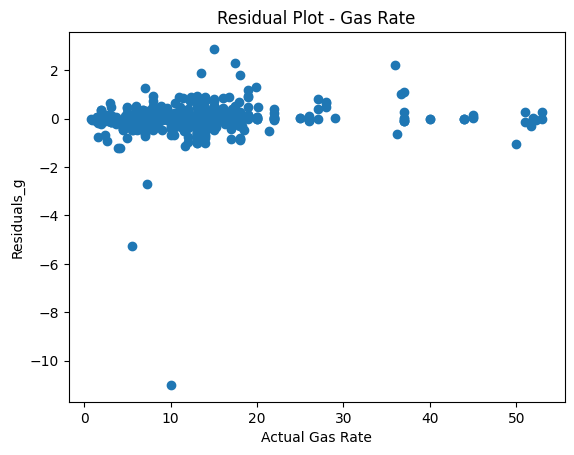

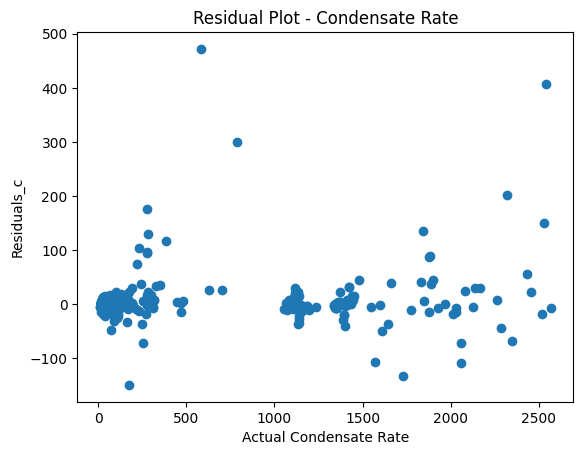

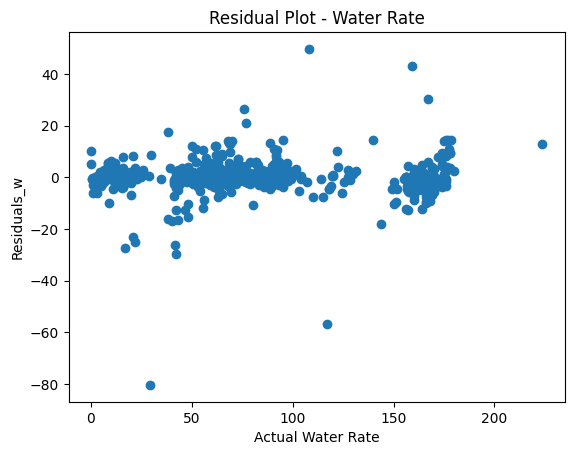

In [56]:
# For Gas
residuals_g = y_g_test - y_g_pred
plt.scatter(y_g_test, residuals_g)
plt.xlabel('Actual Gas Rate')
plt.ylabel('Residuals_g')
plt.title('Residual Plot - Gas Rate')
plt.show()

# For condensate
residuals_c = y_c_test - y_c_pred
plt.scatter(y_c_test, residuals_c)
plt.xlabel('Actual Condensate Rate')
plt.ylabel('Residuals_c')
plt.title('Residual Plot - Condensate Rate')
plt.show()

# For Water
residuals_w = y_w_test - y_w_pred
plt.scatter(y_w_test, residuals_w)
plt.xlabel('Actual Water Rate')
plt.ylabel('Residuals_w')
plt.title('Residual Plot - Water Rate')
plt.show()

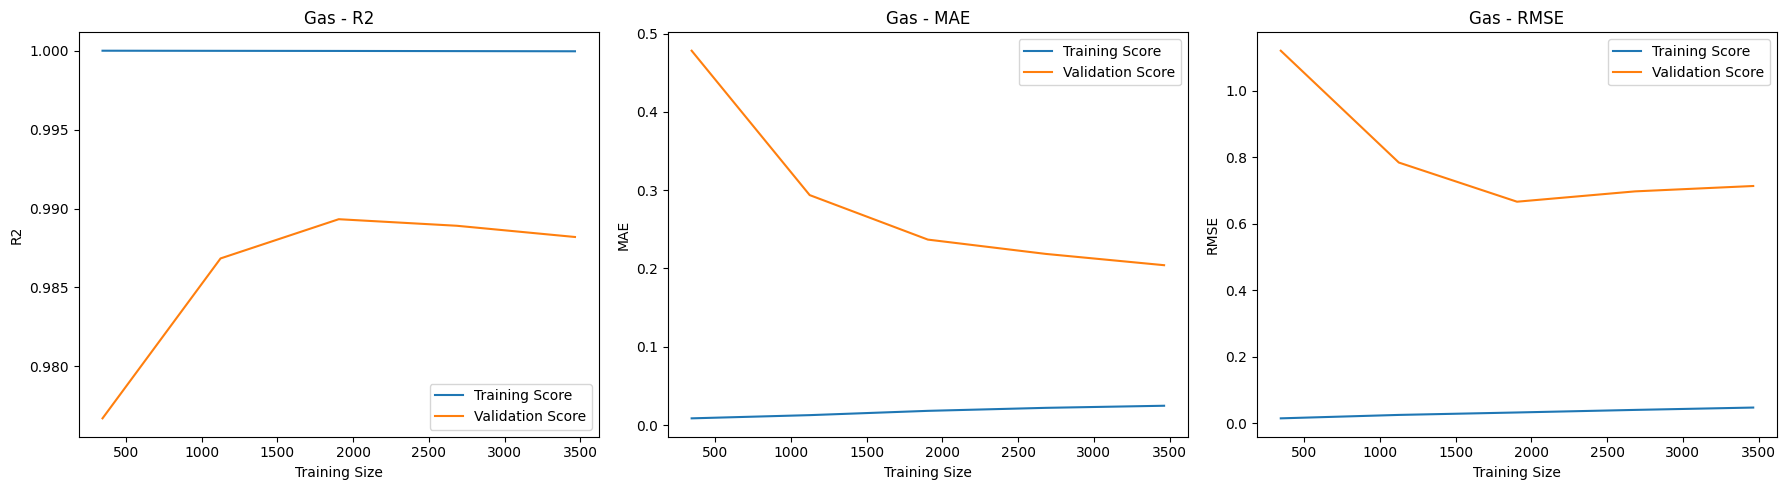

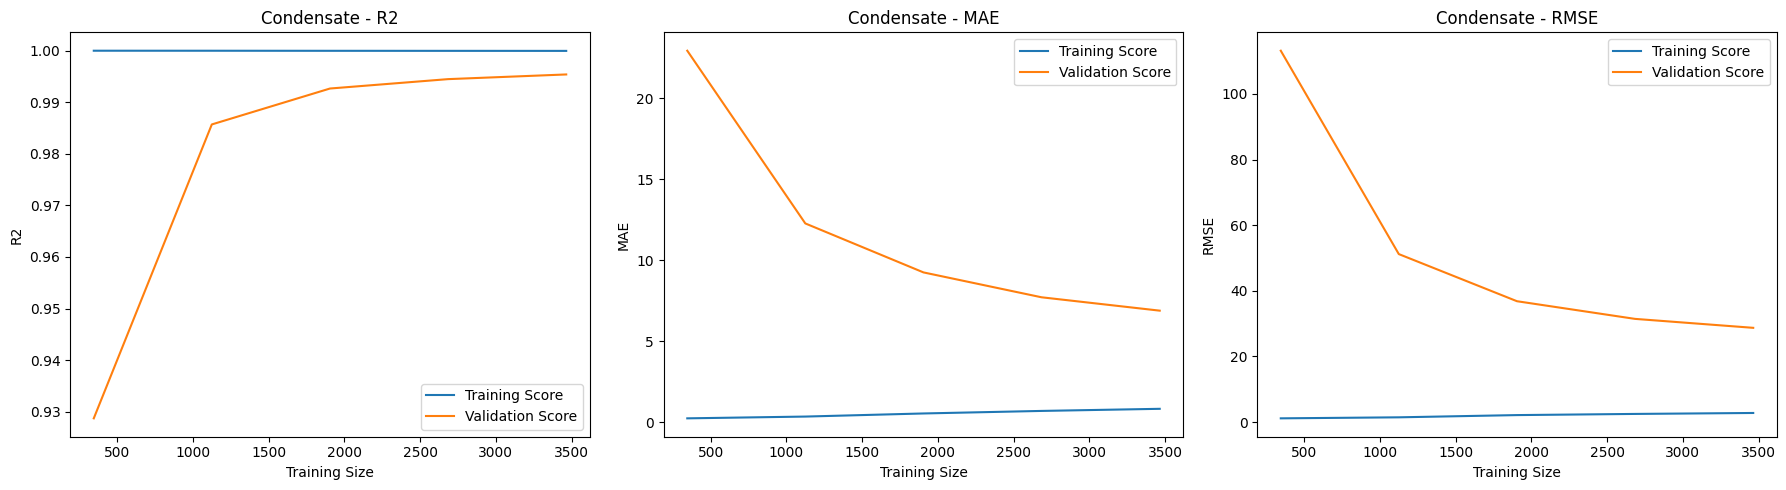

c:\Users\ebkas11\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [10:04:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "regressor__colsample_bytree", "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators", "regressor__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ebkas11\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [10:04:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "regressor__colsample_bytree", "regressor__learning_rate", "regressor__max_depth", "regressor__n_estimators", "regressor__subsample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\ebkas11\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [10:04:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Pa

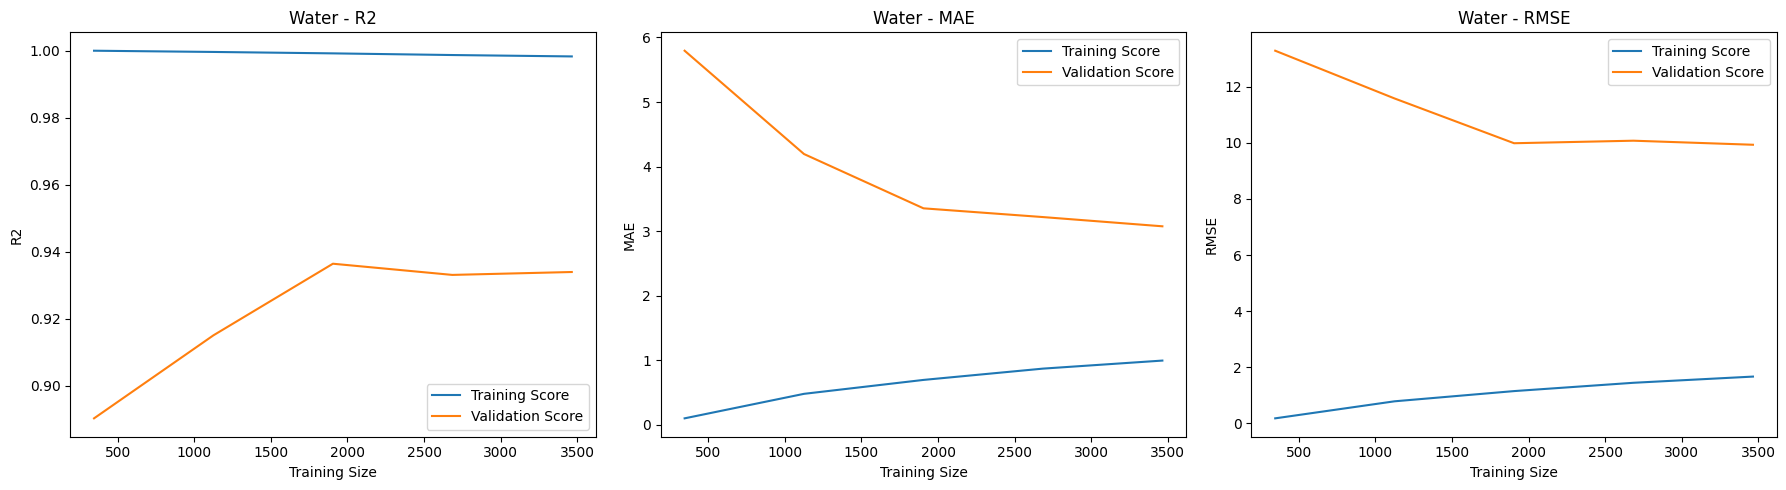

In [28]:
# Define metrics
scorers = {
    'R2': make_scorer(r2_score),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)
}

def plot_learning_curve(model, X, y, label):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (name, scorer) in enumerate(scorers.items()):
        train_sizes, train_scores, test_scores = learning_curve(
            model, X, y, cv=5, scoring=scorer
        )
        train_mean = np.mean(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)

        if name in ['MAE', 'RMSE']:
            # Convert to positive for plotting (since we used greater_is_better=False)
            train_mean *= -1
            test_mean *= -1

        axes[idx].plot(train_sizes, train_mean, label='Training Score')
        axes[idx].plot(train_sizes, test_mean, label='Validation Score')
        axes[idx].set_xlabel("Training Size")
        axes[idx].set_ylabel(name)
        axes[idx].set_title(f'{label} - {name}')
        axes[idx].legend()
    
    plt.tight_layout()
    plt.show()

# Example usage for condensate and water
plot_learning_curve(best_g, X_train, y_g_train, label='Gas')
plot_learning_curve(best_c, X_train, y_c_train, label='Condensate')
plot_learning_curve(best_w, X_train, y_w_train, label='Water')


In [2]:
FEATURES = [
    'THP (bar)', 'FLP (bar)', 'FLT ©', 'Choke (%)',
    'Gas Specific Gravity', 'Oil Gravity (API)',
    'Venturi ΔP1 (mbar)', 'Venturi ΔP2 (mbar)', 'Pressure_ratio', 'dp1_dp2',
    'dP_ratio', 'flow_energy', 'temp_pressure', 'condensate_correction'
]

In [10]:
# ========================================
# 10. Manual Test Input for Prediction
# ========================================
print("\n🔍 Predict on New Input")

# Replace values below with actual well test data
# input with proper feature order

test_input = {
    'THP (bar)': 83.0,
    'FLP (bar)': 41.0,
    'FLT ©': 56.0,
    'Gas Specific Gravity': 0.75,
    'Oil Gravity (API)': 41.7,
    'Venturi ΔP1 (mbar)': 43.0,
    'Venturi ΔP2 (mbar)': 18.0,
    'Choke (%)': 20.0
}


# Feature engineering manually
if test_input['Venturi ΔP1 (mbar)'] != 0:
    test_input['dP_ratio'] = test_input['Venturi ΔP2 (mbar)'] / test_input['Venturi ΔP1 (mbar)']
else:
    test_input['dP_ratio'] = 0.0
test_input['flow_energy'] = test_input['THP (bar)'] * test_input['Venturi ΔP1 (mbar)']
test_input['temp_pressure'] = test_input['FLT ©'] * test_input['THP (bar)']
test_input['Pressure_ratio'] = test_input['FLP (bar)'] / test_input['THP (bar)']
test_input['dp1_dp2'] = test_input['Venturi ΔP1 (mbar)'] * test_input['Venturi ΔP2 (mbar)']
test_input['condensate_correction'] = test_input['temp_pressure'] / test_input['FLP (bar)']
# Convert to DataFrame and reorder columns
X_new = pd.DataFrame([test_input])[FEATURES]

# Load saved models
model_g = joblib.load('model_g_xgb.pkl')
model_c  = joblib.load('model_c_xgb.pkl')
model_w  = joblib.load('model_w_xgb.pkl')

# Predict
y_g_pred = model_g.predict(X_new)
y_c_pred  = model_c.predict(X_new)
y_w_pred  = model_w.predict(X_new)

# Output results
print("\n📈 Predicted Rates:")
print(f"Gas Rate        : {y_g_pred[0]:.2f} MMscf/d")
print(f"Condensate Rate : {y_c_pred[0]:.2f} BBL/d")
print(f"Water Rate      : {y_w_pred[0]:.2f} BBL/d")



🔍 Predict on New Input

📈 Predicted Rates:
Gas Rate        : 4.78 MMscf/d
Condensate Rate : 402.56 BBL/d
Water Rate      : 20.22 BBL/d


In [14]:
# === 1. Load input test data ===
df_test = pd.read_excel(r'E:\khaled\Machine learning\Models\Gas\Code\Original\Test15.xlsx')  # <-- Your input file here

# === 2. Feature Engineering ===
def engineer_features(df):
    df = df.copy()


    df['dP_ratio'] = df['Venturi ΔP2 (mbar)'] / df['Venturi ΔP1 (mbar)'].replace(0, 1e-3)
    df['flow_energy'] = df['THP (bar)'] * df['Venturi ΔP1 (mbar)']
    df['temp_pressure'] = df['FLT ©'] * df['THP (bar)']
    df['Pressure_ratio'] = df['FLP (bar)'] / df['THP (bar)'].replace(0, 1e-3)
    df['dp1_dp2'] = df['Venturi ΔP1 (mbar)'] * df['Venturi ΔP2 (mbar)']
    df['condensate_correction'] = df['temp_pressure'] / df['FLP (bar)'].replace(0, 1e-3)

    return df

df_feat = engineer_features(df_test)

# === 3. Define final features per model ===
BASE_FEATURES = [
    'THP (bar)', 'FLP (bar)', 'FLT ©', 'Choke (%)',
    'Gas Specific Gravity', 'Oil Gravity (API)',
    'Venturi ΔP1 (mbar)', 'Venturi ΔP2 (mbar)', 'Pressure_ratio', 'dp1_dp2',
    'dP_ratio', 'flow_energy', 'temp_pressure', 'condensate_correction'
]


# === 4. Load models ===
model_g = joblib.load('model_g_xgb.pkl')
model_c = joblib.load('model_c_xgb.pkl')
model_w = joblib.load('model_w_xgb.pkl')

# === 5. Predict outputs ===
df_feat['Gas Rate (MMSCFD)'] = model_g.predict(df_feat[BASE_FEATURES])
df_feat['Condensate Rate (BPD)'] = model_c.predict(df_feat[BASE_FEATURES])
df_feat['Water Rate (BPD)'] = model_w.predict(df_feat[BASE_FEATURES])

# === 6. Save predictions ===
df_feat[['Gas Rate (MMSCFD)', 'Condensate Rate (BPD)', 'Water Rate (BPD)']].to_excel('predicted_rates.xlsx', index=False)

print("✅ All predictions saved to 'predicted_rates.xlsx'")


✅ All predictions saved to 'predicted_rates.xlsx'
